In [44]:
import polars as pl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [45]:
# parameter
bins = 200
filtT = 2e-6

In [46]:
df = pl.read_csv("data/lifetime.csv")
df

electron_T,electron_praS,electron_intS,muon_T,muon_praS,muon_intS
f64,f64,f64,f64,f64,f64
1.5256e-9,3.2731e-10,3.8328e-10,-0.000002,1.0571e-9,1.1700e-9
1.0437e-9,4.3698e-10,5.2800e-10,-0.000001,5.8835e-10,6.3672e-10
6.4600e-10,4.0172e-10,4.4784e-10,-5.5615e-7,5.6880e-10,5.7552e-10
7.5818e-10,3.2316e-10,4.1784e-10,-6.5119e-7,6.7000e-10,7.3392e-10
-6.4385e-10,1.6029e-11,2.9280e-11,-7.2548e-7,6.4871e-10,6.5496e-10
…,…,…,…,…,…
9.4775e-10,4.6072e-10,5.1864e-10,-1.1741e-7,7.8286e-10,7.5984e-10
-2.7903e-9,3.5936e-11,3.2640e-11,-3.0206e-7,2.0269e-10,1.6992e-10
-8.4566e-11,3.4047e-10,3.2472e-10,-3.7568e-7,8.1418e-10,8.0040e-10


In [47]:
dT = (df["electron_T"]-df["muon_T"]).to_numpy()
dT

array([1.73727708e-06, 1.33526728e-06, 5.56794611e-07, ...,
       3.75598758e-07, 6.65135778e-07, 7.18841701e-07])

In [48]:
def background(t, C):
    return C * np.ones_like(t)

def muon(t, N0, tau):
    return N0 * np.exp(-t/tau)

def N(t, N0, tau, C):
    return muon(t, N0, tau) + C

In [49]:
dT_hist= np.histogram(dT, bins=bins)
x = dT_hist[1][:-1]
y = dT_hist[0]

In [50]:
len(x), len(y)

(200, 200)

<BarContainer object of 200 artists>

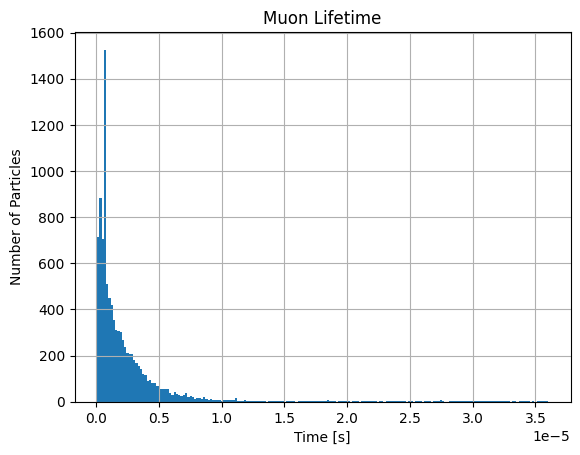

In [51]:
fig, ax = plt.subplots()
ax.set_xlabel("Time [s]")
ax.set_ylabel("Number of Particles")
ax.set_title("Muon Lifetime")
ax
ax.grid()

ax.bar(x, y, width=np.diff(x[:-1])[0], align="edge", label="Data")

In [52]:
popt, pcov = curve_fit(N, x, y, p0=[1000, 2e-6, 0])
N0, tau, C = popt
N0_std, tau_std, C_std = np.sqrt(np.diag(pcov))

print(f"N0 = {N0:.2f} +- {N0_std:.2f}")
print(f"tau = {tau:.2e} +- {tau_std:.2e}")
print(f"C = {C:.2f} +- {C_std:.2f}")

N0 = 1012.27 +- 42.48
tau = 1.66e-06 +- 1.04e-07
C = 3.14 +- 5.05


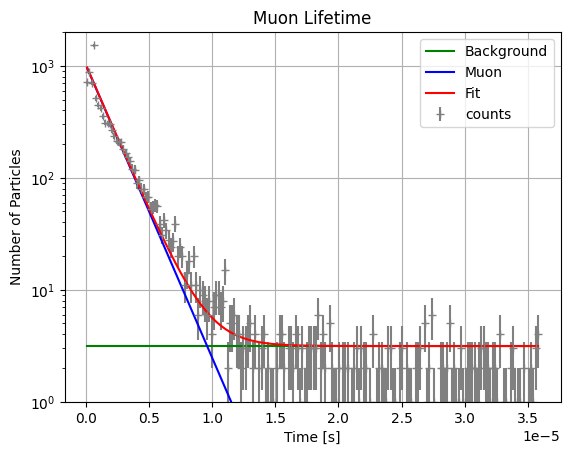

In [53]:
fig, ax = plt.subplots()
ax.set_xlabel("Time [s]") 
ax.set_ylabel("Number of Particles")
ax.set_title("Muon Lifetime")
ax.set_yscale("log")
ax.grid()

ax.set_ylim(1, 2e3)

ax.errorbar(x, y, yerr=np.sqrt(y), fmt="+", label="counts", color="gray")
ax.plot(x, background(x, C), label="Background", color="green")
ax.plot(x, muon(x, N0, tau), label="Muon", color="blue")
ax.plot(x, N(x, *popt), label="Fit", color="red")

ax.legend()

In [54]:
fx = x[x > filtT]
fy = y[x > filtT]

In [56]:
len(fx), len(fy)

(189, 189)

In [61]:
fpopt, fpcov = curve_fit(N, fx, fy, p0=[1000, 2e-6, 0])
fN0, ftau, fC = fpopt
fN0_std, ftau_std, fC_std = np.sqrt(np.diag(fpcov))

print(f"N0 = {fN0:.2f} +- {fN0_std:.2f}")
print(f"tau = {ftau:.2e} +- {ftau_std:.2e}")
print(f"C = {fC:.2f} +- {fC_std:.2f}")

N0 = 736.14 +- 12.26
tau = 2.04e-06 +- 2.29e-08
C = 1.79 +- 0.29


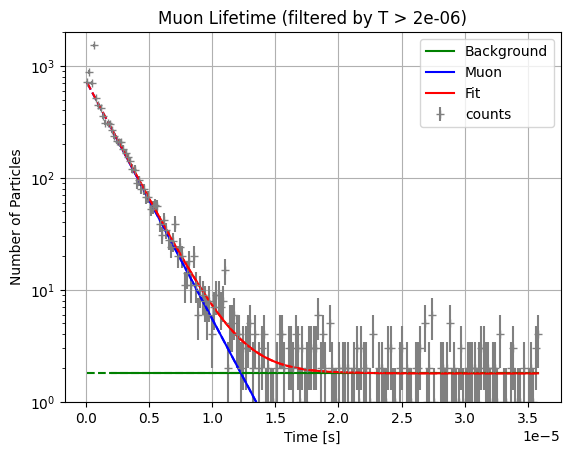

In [67]:
fig, ax = plt.subplots()
ax.set_xlabel("Time [s]") 
ax.set_ylabel("Number of Particles")
ax.set_title("Muon Lifetime (filtered by T > {})".format(filtT))
ax.set_yscale("log")
ax.grid()

ax.set_ylim(1, 2e3)

ax.errorbar(x, y, yerr=np.sqrt(y), fmt="+", label="counts", color="gray")

ax.plot(fx, background(fx, fC), label="Background", color="green")
ax.plot(fx, muon(fx, fN0, ftau), label="Muon", color="blue")
ax.plot(fx, N(fx, *fpopt), label="Fit", color="red")

ax.plot(x, background(x, fC), color="green", linestyle="--")
ax.plot(x, muon(x, fN0, ftau), color="blue", linestyle="--")
ax.plot(x, N(x, *fpopt), color="red", linestyle="--")

ax.legend()